In [ ]:
import ee
ee.Authenticate()

In [ ]:
import os
import pickle
import copy
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import seaborn
from matplotlib import pyplot as plt
from matplotlib import colormaps as cm
from osgeo import gdal
from functools import reduce
from windrose import WindroseAxes

In [ ]:
def polys_critic(i):
    if i.type == "MultiPolygon":
        return [shapely.Polygon(x.exterior.coords) for x in i.geoms]
    else:
        return [shapely.Polygon(i.exterior.coords)]

In [ ]:
###  census subdivision of Saint John
csd_shp = gpd.read_file(f"./Subdivision/lcsd000b21a_e.shp")
csd_sj = csd_shp[csd_shp["CSDNAME"] == "Saint John"]
csd_sj_geom = csd_sj["geometry"].apply(lambda i: polys_critic(i)).explode()
csd_sj_geom_gjs = gpd.GeoDataFrame(csd_sj_geom)
csd_sj_geom_gjs = csd_sj_geom_gjs.set_crs(epsg=3347)
csd_sj_geom_gjs = csd_sj_geom_gjs.to_crs(epsg=4326)

In [ ]:
region = ee.Geometry.Rectangle([np.min(csd_sj_geom_gjs.bounds.minx),
                                np.min(csd_sj_geom_gjs.bounds.miny),
                                np.max(csd_sj_geom_gjs.bounds.maxx),
                                np.max(csd_sj_geom_gjs.bounds.maxy)])

In [ ]:
(np.min(csd_sj_geom_gjs.bounds.minx),
  np.min(csd_sj_geom_gjs.bounds.miny),
  np.max(csd_sj_geom_gjs.bounds.maxx),
  np.max(csd_sj_geom_gjs.bounds.maxy))

(-66.23956457907666, 45.14150349586934, -65.83883175626757, 45.3774825105468)

In [ ]:
for band in ['UGRD', 'VGRD', 'WDIR', 'WIND']:

    rtma = ee.ImageCollection('NOAA/NWS/RTMA') \
              .filterDate("2022-01-01", "2023-01-01") \
              .select(band) \
              .map(lambda x: x.clip(region)) \
              .reduce(ee.Reducer.mean())

    tasks = ee.batch.Export.image.toDrive(**{
            'image': rtma,
            'description': "saint_john_2022_" + band,
            'folder': "rtma_windrose",
            'region': region,
            'scale': 2500,
            'fileFormat':'GeoTIFF',
            'crs':'EPSG:4326'
    })
    tasks.start()

In [ ]:
for band in ['UGRD', 'VGRD', 'WDIR', 'WIND']:

    rtma = ee.ImageCollection('NOAA/NWS/RTMA') \
              .filterDate("2023-01-01", "2024-01-01") \
              .select(band) \
              .map(lambda x: x.clip(region)) \
              .reduce(ee.Reducer.mean())

    tasks = ee.batch.Export.image.toDrive(**{
            'image': rtma,
            'description': "saint_john_2023_" + band,
            'folder': "rtma_windrose",
            'region': region,
            'scale': 2500,
            'fileFormat':'GeoTIFF',
            'crs':'EPSG:4326'
    })
    tasks.start()

In [ ]:
rtma = ee.ImageCollection('NOAA/NWS/RTMA') \
          .filterDate("2023-01-01", "2024-01-01") \
          .select('WIND') \
          .map(lambda x: x.clip(region)) \
          .reduce(ee.Reducer.mean())

coordinates = rtma.pixelLonLat().select(['longitude','latitude'])

tasks = ee.batch.Export.image.toDrive(**{
        'image': coordinates,
        'description': "saint_john_coords",
        'folder': "rtma_windrose",
        'region': region,
        'scale': 2500,
        'fileFormat':'GeoTIFF',
        'crs':'EPSG:4326'
})
tasks.start()

In [ ]:
features_2022 = []
features_2023 = []

feature_coords = gdal.Open(folder + "saint_john_coords.tif")
lat = np.array(feature_coords.GetRasterBand(2).ReadAsArray())
lon = np.array(feature_coords.GetRasterBand(1).ReadAsArray())

for band in ['UGRD', 'VGRD', 'WDIR', 'WIND']:

    tem = gdal.Open(folder + "saint_john_2022_" + band + ".tif")
    tem = np.array(tem.GetRasterBand(1).ReadAsArray())
    obs = pd.DataFrame({
        "longitude": lon.flatten(),
        "latitude": lat.flatten(),
        band: tem.flatten()
    })

    features_2022.append(obs)

    tem = gdal.Open(folder + "saint_john_2023_" + band + ".tif")
    tem = np.array(tem.GetRasterBand(1).ReadAsArray())
    obs = pd.DataFrame({
        "longitude": lon.flatten(),
        "latitude": lat.flatten(),
        band: tem.flatten()
    })

    features_2023.append(obs)

In [ ]:
features_df_2022 = reduce(lambda df1, df2: pd.merge(df1, df2, on=["longitude", "latitude"]), features_2022)
features_df_2023 = reduce(lambda df1, df2: pd.merge(df1, df2, on=["longitude", "latitude"]), features_2023)
features_df = pd.concat([features_df_2022, features_df_2023])
features_df = features_df.dropna()

In [ ]:
features_df

,longitude,latitude,UGRD,VGRD,WDIR,WIND
0,-66.239523,45.376151,0.663477,0.398994,197.845174,3.387321
1,-66.217065,45.376151,0.663477,0.398994,197.845174,3.387321
2,-66.194607,45.376151,0.606279,0.407027,193.497332,2.966693
3,-66.172150,45.376151,0.696924,0.539878,198.911296,3.366181
4,-66.149692,45.376151,0.696924,0.539878,198.911296,3.366181
...,...,...,...,...,...,...
204,-65.925113,45.151572,0.751431,-0.841766,195.838323,6.101154
205,-65.902655,45.151572,0.825790,-0.969852,195.273776,6.103244
206,-65.880197,45.151572,0.825790,-0.969852,195.273776,6.103244
207,-65.857739,45.151572,0.899782,-0.899307,193.313934,6.232500


Text(0.5, 1.0, 'Average U- and V- Components Wind in Saint John during 2022 - 2023')

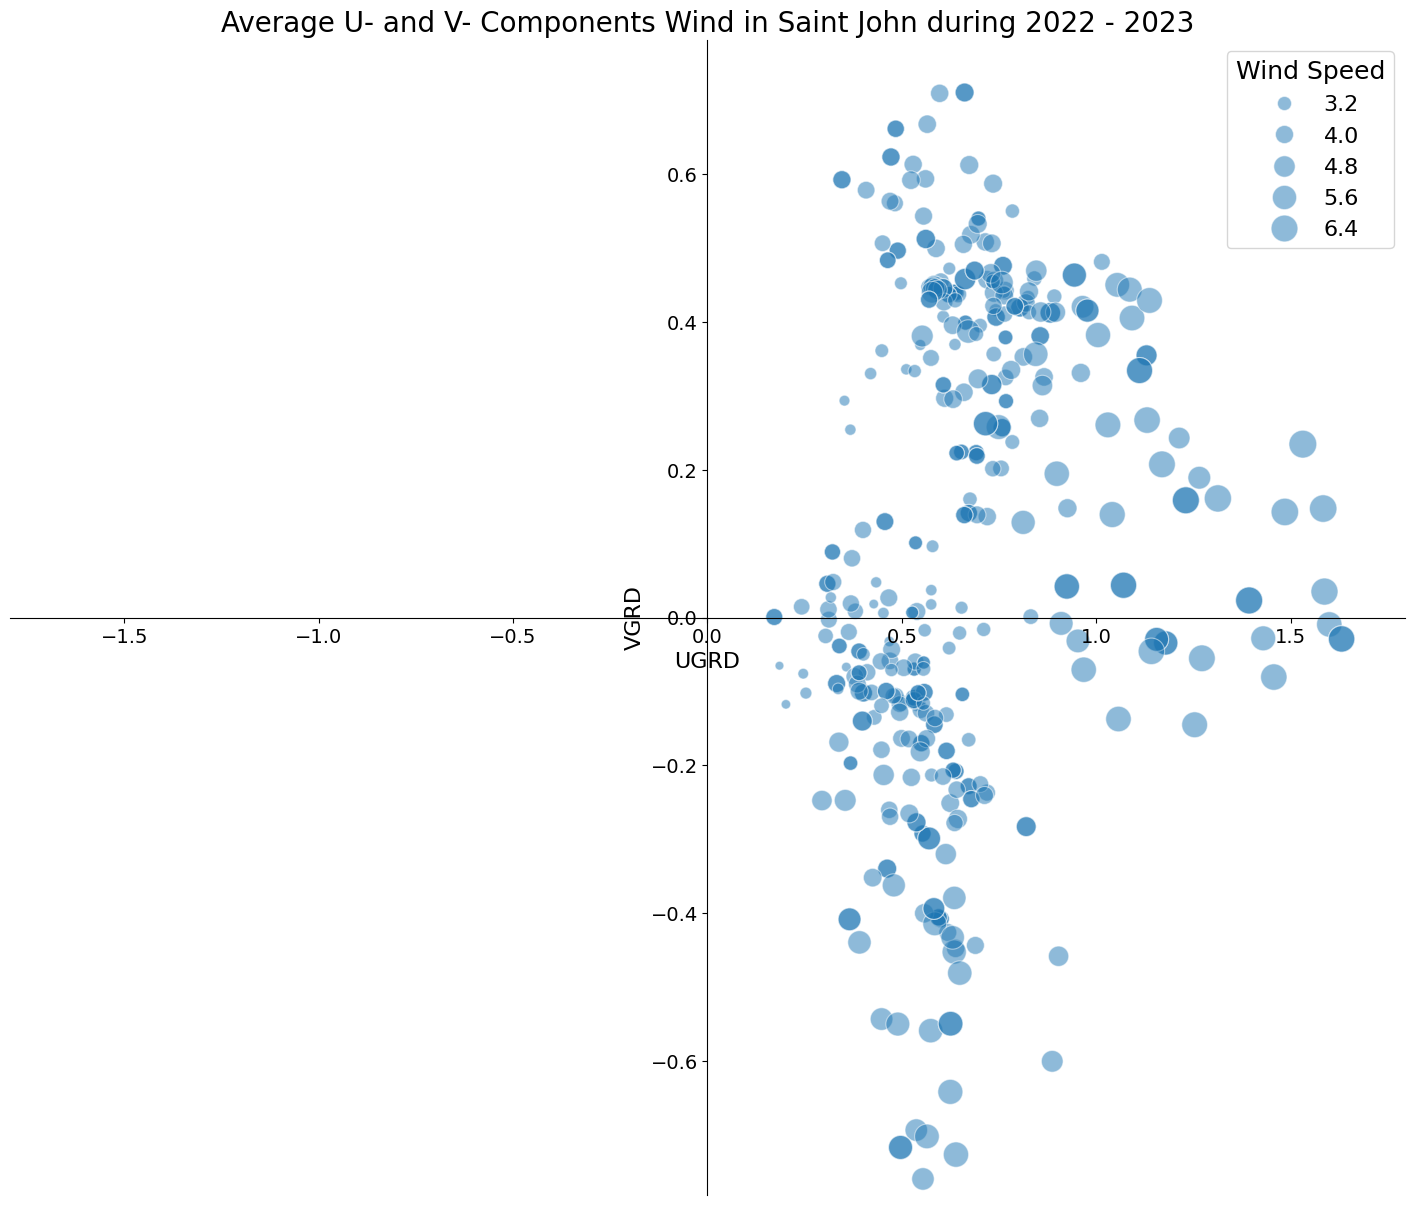

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18, 15))

seaborn.scatterplot(
    data = features_df,
    x = "UGRD",
    y = "VGRD",
    size = "WIND",
    sizes=(40, 400), alpha=.5,
    ax = ax
)

ax.set_ylim([np.max(features_df['VGRD']) * -1.1, np.max(features_df['VGRD']) * 1.1])
ax.set_xlim([np.max(features_df['UGRD']) * -1.1, np.max(features_df['UGRD']) * 1.1])
ax.axhline(0, color='black', linewidth=.5)
ax.axvline(0, color='black', linewidth=.5)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_xlabel("UGRD", fontsize=16)
ax.set_ylabel("VGRD", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=16, title='Wind Speed', title_fontsize=18)
ax.set_title("Average U- and V- Components Wind in Saint John during 2022 - 2023", fontsize=20)

In [ ]:
###  call new brunswick air quality monitoring station data
nb_stations = pd.read_excel(f"/content/drive/MyDrive/TEMPO/Air Quality Data/NB_Air_Quality_stations_metadata.xlsx")

nb_stations = nb_stations[(nb_stations['city'].isin(['Saint John','Colson Cove'])) & (nb_stations['measurements'].isin(["SO2","TRS"]))]
nb_stations = nb_stations[~((nb_stations['station_name'] == "Forest Hills") & (nb_stations['owner'] == "Government of New Brunswick"))]
nb_stations = nb_stations[nb_stations['station_name'] != "Musquash"]
nb_stations = nb_stations[nb_stations['station_name'] != "Milford"]
nb_stations = nb_stations[nb_stations['station_name'] != "Saint John Street"]

nb_stations['geometry'] = list(zip(nb_stations['longitude'], nb_stations['latitude']))
nb_stations['geometry'] = nb_stations['geometry'].apply(shapely.Point)
nb_stations = gpd.GeoDataFrame(nb_stations, geometry='geometry', crs = 'epsg:4326')

In [ ]:
nb_stations

,id,station_name,province,city,latitude,longitude,owner,measurements,geometry
39,3,West Side,New Brunswick,Saint John,45.253150,-66.079931,Government of New Brunswick,SO2,POINT (-66.07993 45.25315)
40,8,Expansion Ave,New Brunswick,Saint John,45.275000,-66.002222,Irving Oil Ltd,SO2,POINT (-66.00222 45.275)
41,9,Silver Falls Site,New Brunswick,Saint John,45.297944,-66.007250,Irving Oil Ltd,SO2,POINT (-66.00725 45.29794)
43,19,Champlain Heights,New Brunswick,Saint John,45.291222,-66.002917,Irving Oil Ltd,SO2,POINT (-66.00292 45.29122)
46,28,Midwood Ave.,New Brunswick,Saint John,45.267736,-66.017017,Irving Oil Ltd,SO2,POINT (-66.01702 45.26774)
47,30,Castle Street,New Brunswick,Saint John,45.280278,-66.056111,Government of New Brunswick,SO2,POINT (-66.05611 45.28028)
49,76,Grandview west site,New Brunswick,Saint John,45.273342,-66.013944,Irving Oil Ltd,SO2,POINT (-66.01394 45.27334)
51,11,Sherbrook St.,New Brunswick,Saint John,45.252778,-66.095278,Irving Pulp and Paper Ltd,SO2,POINT (-66.09528 45.25278)
53,13,Bridge Street,New Brunswick,Saint John,45.275556,-66.088611,Irving Pulp and Paper Ltd,SO2,POINT (-66.08861 45.27556)
55,31,Lorneville cemetary,New Brunswick,Colson Cove,45.174903,-66.166046,&#201;nergie NB Power,SO2,POINT (-66.16605 45.1749)


Text(0.5, 1.0, 'Average U- and V- Components Wind around Oil Refinery in East Saint John during 2022 - 2023')

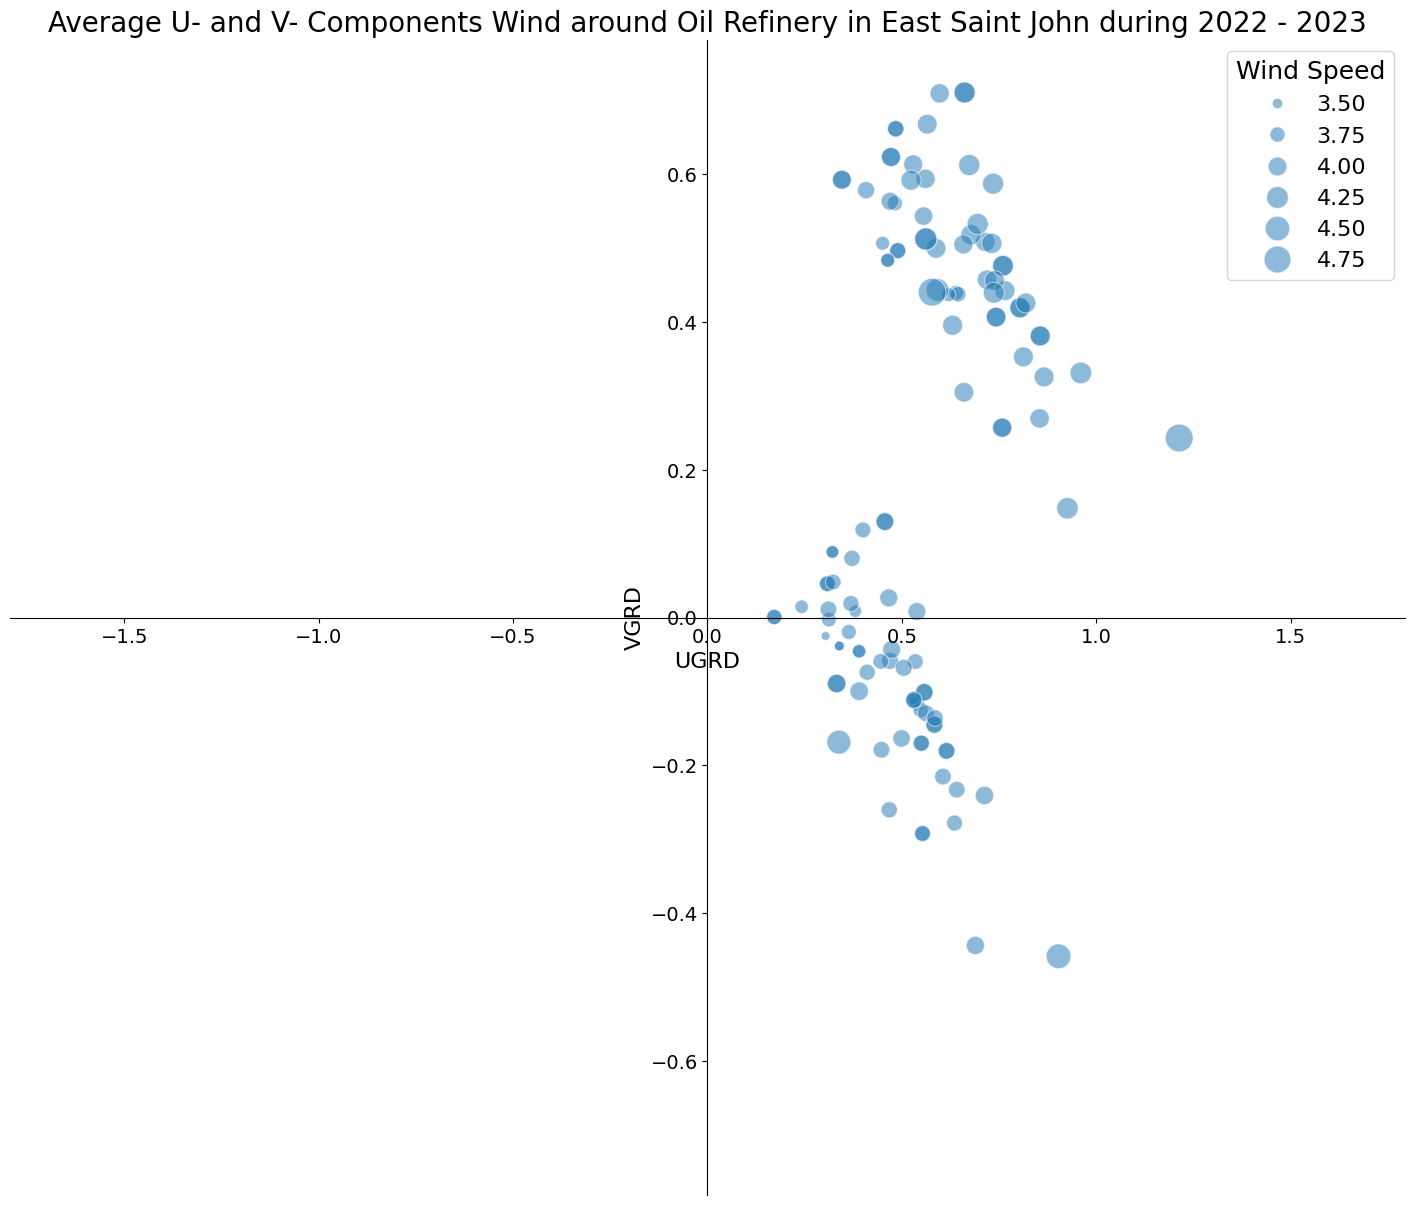

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18, 15))

seaborn.scatterplot(
    data = features_df[(features_df['longitude'] >= -66.05) &
                       (features_df['latitude'] >= 45.26)],
    x = "UGRD",
    y = "VGRD",
    size = "WIND",
    sizes=(40, 400), alpha=.5,
    ax = ax
)

ax.set_ylim([np.max(features_df['VGRD']) * -1.1, np.max(features_df['VGRD']) * 1.1])
ax.set_xlim([np.max(features_df['UGRD']) * -1.1, np.max(features_df['UGRD']) * 1.1])
ax.axhline(0, color='black', linewidth=.5)
ax.axvline(0, color='black', linewidth=.5)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_xlabel("UGRD", fontsize=16)
ax.set_ylabel("VGRD", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=16, title='Wind Speed', title_fontsize=18)
ax.set_title("Average U- and V- Components Wind around Oil Refinery in East Saint John during 2022 - 2023", fontsize=20)

Text(0.5, 1.0, 'Annual Mean Wind Speed and Direction in Saint John during 2022 - 2023')

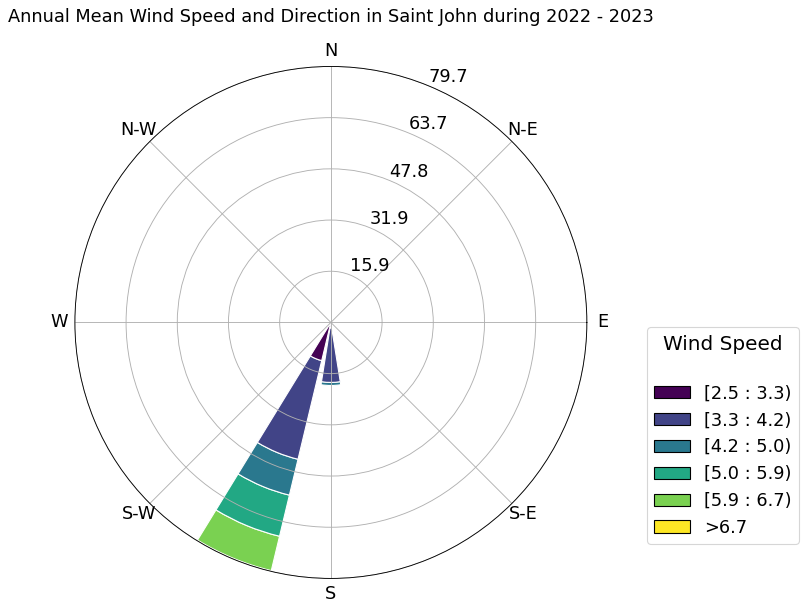

In [ ]:
ax = WindroseAxes.from_ax()
ax.bar(features_df['WDIR'], features_df['WIND'], normed=True, opening=0.8, edgecolor='white')
ax.legend(title="Wind Speed\n", bbox_to_anchor=(1.1, 0.05), fontsize=16, title_fontsize=18)
ax.set_xticklabels([i.get_text() for i in ax.get_xticklabels()], fontsize = 16)
ax.set_yticklabels([i.get_text() for i in ax.get_yticklabels()], fontsize = 16)
ax.set_title("Annual Mean Wind Speed and Direction in Saint John during 2022 - 2023", pad=40, fontsize=16)

Text(0.5, 1.0, 'Annual Mean Wind Speed and Direction around Oil Refinery in East Saint John \nduring 2022 - 2023')

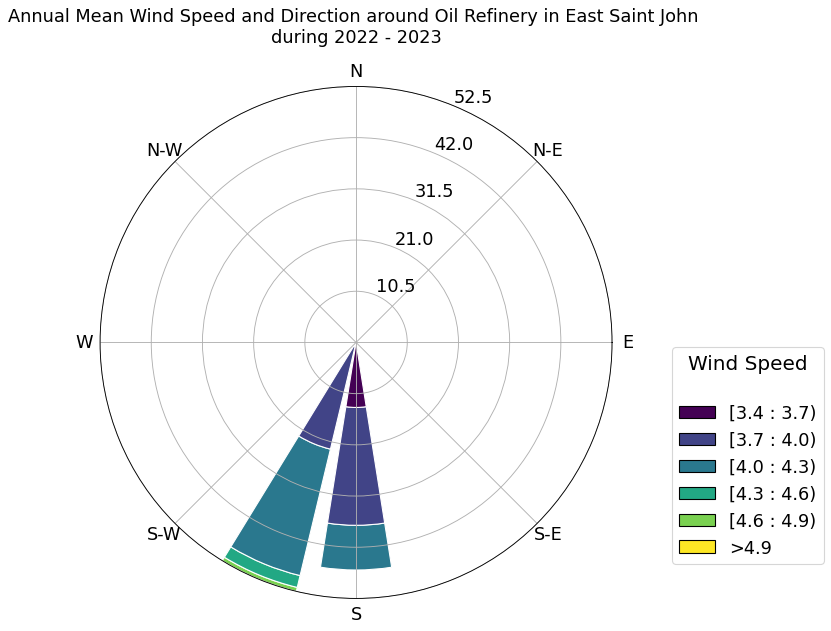

In [ ]:
ax = WindroseAxes.from_ax()
ax.bar(features_df[(features_df['longitude'] >= -66.05) &
                   (features_df['latitude'] >= 45.26)]['WDIR'],
       features_df[(features_df['longitude'] >= -66.05) &
                   (features_df['latitude'] >= 45.26)]['WIND'],
       normed=True, opening=0.8, edgecolor='white')
ax.legend(title="Wind Speed\n", bbox_to_anchor=(1.1, 0.05), fontsize=16, title_fontsize=18)
ax.set_xticklabels([i.get_text() for i in ax.get_xticklabels()], fontsize = 16)
ax.set_yticklabels([i.get_text() for i in ax.get_yticklabels()], fontsize = 16)
ax.set_title("Annual Mean Wind Speed and Direction around Oil Refinery in East Saint John \nduring 2022 - 2023", pad=40, fontsize=16)